# Problem Definition

The image classification problem is _Road Sign Classification_, which aims to classify images of road signs into **five** different categories:

    Keep Left
    No Left Turn
    No Right Turn
    Pedestrian Crossing
    Speed Limit

The dataset is already collected, and we have 3826 images for training, 388 images for validation, and 185 images for testing.

### Preprocessing:
Finding an appropriate dataset was a challenge. After extensive searching, I [discovered a dataset on Roboflow](https://universe.roboflow.com/elec5308-w8jl5/australia-traffic-sign), which contains images captured from a YouTube video of driving in Melbourne. The dataset was modified to suit my needs:

    Object Isolation: As the original data contained entire street views, I isolated the relevant road signs to create clean, focused images for classification.
    Null Value Removal: All incomplete or irrelevant data entries were removed for data quality.

Theoretical and practical challenges:

    Variability in image quality, lighting, and background;
    > The dataset consists of screenshots from a video, leading to variations in lighting, sharpness, and resolution.
    Similarity between some road signs (No Left Turn and No Right Turn);
    > No Left Turn" and "No Right Turn" signs are similar visually, so it might be difficult to differentiate. In my previous training attempts, I have tried to use horizontally flipped versions of No Left Turn as training data for No Right Turn, and it ended up with my model incorrectly classifying the labels more than half of the time for either features.

    Class imbalance;
    Computational budget limitations (should not be an issue as I am using a small dataset).

Desired inputs/outputs:

    Input: Image of a road sign
    Output: Class label of the road sign (one of five categories)

Target classes:

    Binary classification:
        Keep Left (0 or 1)
        No Left Turn (0 or 1)
        No Right Turn (0 or 1)
        Pedestrian Crossing (0 or 1)
        Speed Limit (0 or 1)

Each image can only belong to one class, making this a **multi-class classification** problem.

# Plan

    Dataset:
      Number of images:
        Training: 3826
        Testing: 185
        Validation: 388

        (80-10-10 split)

    Image labeling: The images are already labeled with their corresponding class labels.

    Model evaluation:
        Accuracy (overall accuracy and per-class accuracy)
        Precision (overall and per-class)
        Recall (overall and per-class)
        F1-score (overall and per-class)


# Solution

### **Data Preprocessing**

    Image Resizing:
    Images have been resized to 224x224 pixels to ensure consistency in input shape.

    Normalization:
    Initially, I used the mean and standard deviation from the ImageNet dataset for normalization.
    However, I have decided to compute the mean and standard deviation from my own dataset to make the solution more self-contained.
    This ensures the normalization is fully based on the distribution of my data:


        Mean: [0.47709652 0.44380783 0.43589283]
        Standard Deviation: [0.1366686  0.14250443 0.1436675 ]

    Class Balancing: Although class imbalance was identified as a potential issue, no undersampling or oversampling was applied in the final implementation. The dataset has been used as-is for training, validation, and testing.

### **Model Design**

My Convolutional Neural Network (CNN) architecture is as follows:

    3 Convolutional Layers: Each followed by ReLU activation and max pooling;

    2 Fully Connected Layers: The first layer reduced the dimensionality of the feature maps, and the second layer produced the final class predictions;

    Activation Functions: ReLU was used for non-linear activation, and the final layer used Softmax for multi-class classification.

### **Model Training**

The model was trained for 12 epochs with a batch size of 32. I used the **Adam optimizer** with a learning rate of **0.001** and **CrossEntropyLoss** as my loss function:

```
Epoch 1, Loss: 0.997
Epoch 2, Loss: 0.536
Epoch 3, Loss: 0.457
Epoch 4, Loss: 0.378
Epoch 5, Loss: 0.273
Epoch 6, Loss: 0.206
Epoch 7, Loss: 0.177
Epoch 8, Loss: 0.143
Epoch 9, Loss: 0.124
Epoch 10, Loss: 0.094
Epoch 11, Loss: 0.121
Epoch 12, Loss: 0.084
Model saved successfully.
```

### **Model Testing**

The model has been tested on the test dataset (185 images), and the following metrics were obtained:

    Test Loss: 0.44
    Average Test Accuracy: 86.98%
    Overall Accuracy: 87.50%
    Overall Precision: 89.84%
    Overall Recall: 82.66%
    Overall F1-Score: 85.15%

### **Class Metrics:**

    Keep Left:
        Precision: 100.00%
        Recall: 85.19%
        F1-Score: 92.00%

    No Left Turn:
        Precision: 85.71%
        Recall: 78.26%
        F1-Score: 81.82%

    No Right Turn:
       Precision: 73.81%
       Recall: 91.18%
       F1-Score: 81.58%

    Pedestrian Crossing:
       Precision: 100.00%
       Recall: 64.71%
       F1-Score: 78.57%

    Speed Limit:
       Precision: 89.66%
       Recall: 93.98%
       F1-Score: 91.76%

I have created a **confusion matrix** to visualize the model's performance across different classes to highlight areas where the model occasionally confused similar signs, such as **"No Left Turn"** and **"No Right Turn."**




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HLRTvemhfGL4kjXPoTsy")
project = rf.workspace("sit319ass2").project("aus-road-sign-small-hptnx")
version = project.version(1)
dataset = version.download("multiclass")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AUS-road-sign-Small-1 in multiclass:: 100%|██████████| 4404/4404 [00:01<00:00, 3597.65it/s]


Number of images in train folder: 3825

Class distribution:
 Keep Left               618
 No Left Turn            366
 No Right Turn           774
 Pedestrian Crossing     279
 Speed Limit            1788
dtype: int64


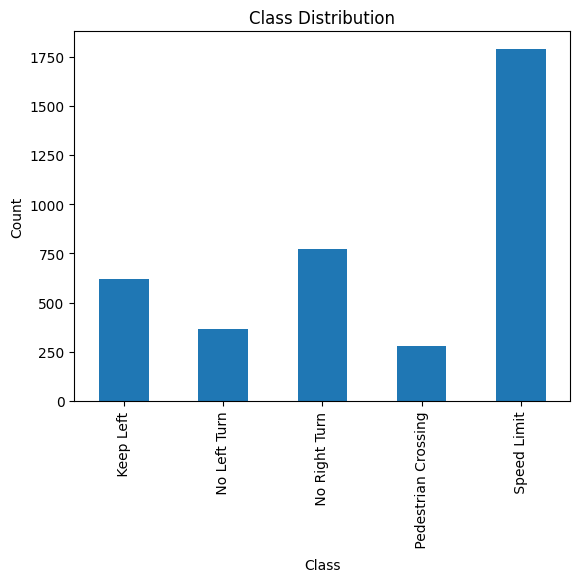


Displaying one image from each class:


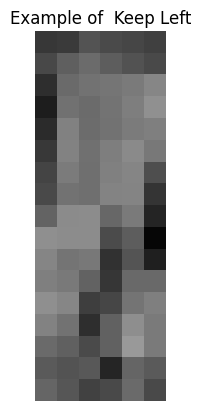

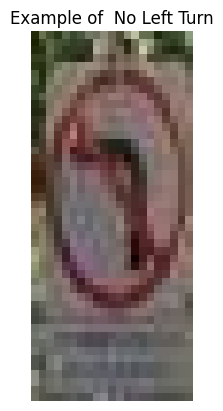

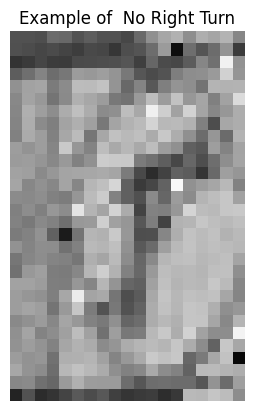

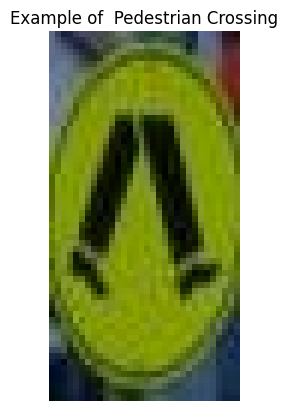

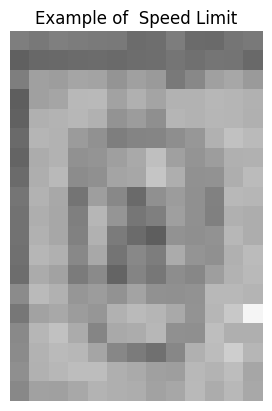

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def display_image(image_path, title): #display imgs in plot
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

data_dir = '/content/AUS-road-sign-Small-1'
train_dir = os.path.join(data_dir, 'train')
train_csv = os.path.join(train_dir, '_classes.csv')

train_df = pd.read_csv(train_csv)

print(f"Number of images in train folder: {len(os.listdir(train_dir)) - 1}")#exclude csv

class_counts = train_df.iloc[:, 1:].sum()
print("\nClass distribution:")
print(class_counts)

class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("\nDisplaying one image from each class:")
for class_name in train_df.columns[1:]:
        #one image per class
    class_images = train_df[train_df[class_name] == 1]["filename"]
    if not class_images.empty:
        image_file = class_images.iloc[0]
        image_path = os.path.join(train_dir, image_file)
        display_image(image_path, f"Example of {class_name}")
    else:
        print(f"No images found for class {class_name}")


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RoadSignDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.df.iloc[index, 0])
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)#apply transform

        label = torch.tensor(self.df.iloc[index, 1:].values.astype(np.float32))
        return image, label

In [5]:
num_images = 0
mean = np.zeros(3)
std = np.zeros(3)

#loop over all images
for image_name in os.listdir(train_dir):
    if image_name.endswith(".jpg"):
        image_path = os.path.join(train_dir, image_name)
        image = Image.open(image_path)
        image = np.array(image) / 255.0  #normalize [0,1] pixel values

        if len(image.shape) == 3:  #if RGB
            mean += image.mean(axis=(0, 1))
            std += image.std(axis=(0, 1))
            num_images += 1

mean /= num_images #compute final mean & std
std /= num_images

print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")


Dataset Mean: [0.47709652 0.44380783 0.43589283]
Dataset Std: [0.1366686  0.14250443 0.1436675 ]


In [6]:
train_df = pd.read_csv('/content/AUS-road-sign-Small-1/train/_classes.csv')
train_image_dir = '/content/AUS-road-sign-Small-1/train'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.47709652, 0.44380783, 0.43589283], std=[0.1366686, 0.14250443, 0.1436675])
])

train_dataset = RoadSignDataset(train_df, train_image_dir, train_transform)

#data loader for training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:

class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()
        # 1st convlayer: 3 input channel (RGB), 32 output channel, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pool
        # 2nd convlayer: 32 input channel, 64 output channel, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 3rd convlayer: 64 input channel, 128 output channel, 3x3 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        #fc layers below:
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 5)#5 classes as output

    def forward(self, x):
        #Conv+pool layers w/ ReLU
        x = self.pool(torch.relu(self.conv1(x)))  # conv+pool layer 1
        x = self.pool(torch.relu(self.conv2(x)))  #conv+pool layer 2
        x = self.pool(torch.relu(self.conv3(x)))  # conv+pool layer 3
        x = x.view(-1, 128 * 28 * 28)  # flatten
        x = torch.relu(self.fc1(x))  # FC 1
        x = self.fc2(x)  # output layer
        return x

#init model, loss function, optimizer;
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ScratchCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train model
for epoch in range(12):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))#class indices for crossEntropyLoss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d, Loss: %.3f' % (epoch+1, running_loss/(i+1)))

#save model
torch.save(model.state_dict(), 'roadsign_model.pth')
print('Model saved successfully.')


Epoch 1, Loss: 0.964
Epoch 2, Loss: 0.520
Epoch 3, Loss: 0.389
Epoch 4, Loss: 0.310
Epoch 5, Loss: 0.246
Epoch 6, Loss: 0.214
Epoch 7, Loss: 0.176
Epoch 8, Loss: 0.118
Epoch 9, Loss: 0.122
Epoch 10, Loss: 0.082
Epoch 11, Loss: 0.070
Epoch 12, Loss: 0.153
Model saved successfully.


In [8]:
#load model
model = ScratchCNN().to(device)
model.load_state_dict(torch.load('roadsign_model.pth', map_location=device))
model.eval()  #set model to eval mode
print('Model loaded successfully.')

Model loaded successfully.


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [9]:
#load test dataset
test_df = pd.read_csv('/content/AUS-road-sign-Small-1/test/_classes.csv')
test_image_dir = '/content/AUS-road-sign-Small-1/test'

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.47709652, 0.44380783, 0.43589283], std=[0.1366686, 0.14250443, 0.1436675])
])

test_dataset = RoadSignDataset(test_df, test_image_dir, test_transform)

# create loader for test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#functions to calculate metrics
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels.argmax(1)).sum().item()
    accuracy = correct / labels.shape[0]
    return accuracy

def calculate_mse(outputs, labels):
    return ((outputs - labels) ** 2).sum(dim=1).mean().item()

#test model on test set
model.eval()
test_loss = 0
test_accuracy = 0
correct_labels = []
predicted_labels = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        test_accuracy += calculate_accuracy(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        correct_labels.extend(labels.argmax(1).cpu().numpy())

#calculate avg accuracy & loss
average_test_loss = test_loss / len(test_loader)
average_test_accuracy = test_accuracy / len(test_loader)

#calculate MSE for EACH class
model.eval()
mse_values = []
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        mse = calculate_mse(outputs, labels)
        mse_values.append(mse)

#overall metrics
accuracy = accuracy_score(correct_labels, predicted_labels)
precision = precision_score(correct_labels, predicted_labels, average='macro')
recall = recall_score(correct_labels, predicted_labels, average='macro')
f1 = f1_score(correct_labels, predicted_labels, average='macro')

#class metrics
class_precision = precision_score(correct_labels, predicted_labels, average=None)
class_recall = recall_score(correct_labels, predicted_labels, average=None)
class_f1 = f1_score(correct_labels, predicted_labels, average=None)

print(f'Test Loss: {average_test_loss:.2f}')
print(f'Average Test Accuracy: {average_test_accuracy * 100:.2f}%')
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Precision: {precision * 100:.2f}%")
print(f"Overall Recall: {recall * 100:.2f}%")
print(f"Overall F1-Score: {f1 * 100:.2f}%")

for i, class_name in enumerate(train_df.columns[1:]):
    print(f"\nClass: {class_name}")
    print(f"  Precision: {class_precision[i] * 100:.2f}%")
    print(f"  Recall: {class_recall[i] * 100:.2f}%")
    print(f"  F1-Score: {class_f1[i] * 100:.2f}%")


Test Loss: 0.42
Average Test Accuracy: 93.40%
Overall Accuracy: 93.48%
Overall Precision: 94.56%
Overall Recall: 91.66%
Overall F1-Score: 92.98%

Class:  Keep Left
  Precision: 100.00%
  Recall: 92.59%
  F1-Score: 96.15%

Class:  No Left Turn
  Precision: 90.91%
  Recall: 86.96%
  F1-Score: 88.89%

Class:  No Right Turn
  Precision: 88.89%
  Recall: 94.12%
  F1-Score: 91.43%

Class:  Pedestrian Crossing
  Precision: 100.00%
  Recall: 88.24%
  F1-Score: 93.75%

Class:  Speed Limit
  Precision: 93.02%
  Recall: 96.39%
  F1-Score: 94.67%


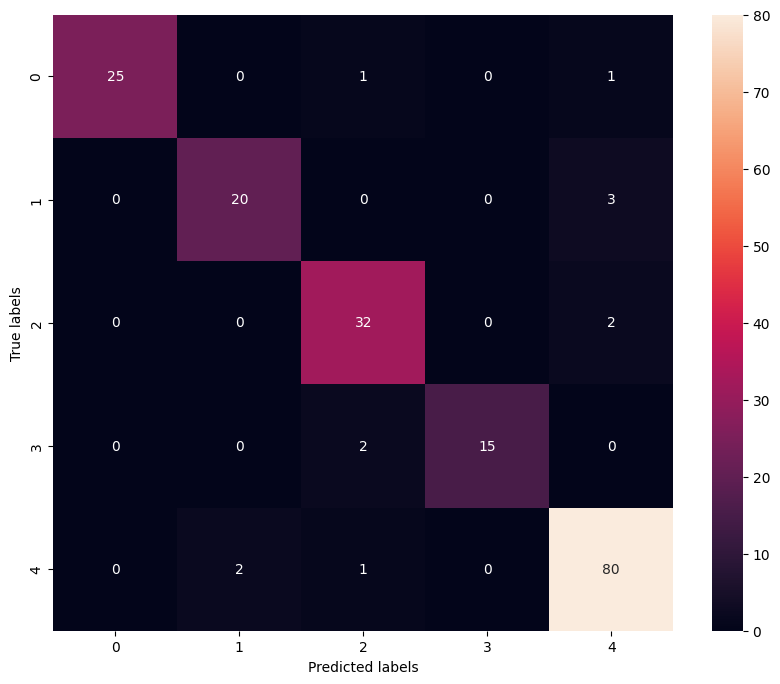

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()